In [1]:
import pandas as pd
import collections
import re
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Import the dataset once in for all and copy it for reuse

In [2]:
df_original = pd.read_csv('reduced_data.csv')

## Create a copy of the dataset
This can be run anytime to "reset" the dataset to its initial state. This is a very quick operation comparing to re reading the whole file.

In [3]:
df = df_original.copy()

# Pre processing

## Remove rows with empty values fopr 'ingredients_tags'

In [4]:
print("Len before removing empty values:", len(df))
# Remove rows with empty ingredients_tags
df = df[df['ingredients_tags'].notna()].reset_index(drop=True)
print("Len after removing empty values:", len(df))

Len before removing empty values: 2614147
Len after removing empty values: 795133


## Replace '-' with spaces

In [5]:
# Replace all '-' with ' ' in ingredients_tags
df['ingredients_tags'] = df['ingredients_tags'].str.replace('-', ' ')

## Split the ingredients into a list object

In [6]:
# For each row, split the ingredients_tags into a list
df['ingredients_tags_lists'] = df['ingredients_tags'].str.split(',')
print("Type of ingredients_tags_lists:", type(df['ingredients_tags_lists'][0]))

Type of ingredients_tags_lists: <class 'list'>


Our new column type is a python list. We will remove the language tag for each ingredient

In [7]:
# Remove the language tag (e.g. 'en:' from the ingredients_tags) by keeping only the part of the string after the 3rd character
df['ingredients_tags_lists'] = df['ingredients_tags_lists'].apply(lambda x: [s[3:] for s in x])

In [8]:
df.head()

,url,product_name,generic_name,quantity,brands,categories,countries,ingredients_text,ingredients_tags,nutriscore_score,nutriscore_grade,pnns_groups_1,pnns_groups_2,food_groups,food_groups_tags,food_groups_en,completeness,main_category_en,ingredients_tags_lists
0,http://world-en.openfoodfacts.org/product/0000...,L.casei,NaN,NaN,NaN,NaN,Spain,"Leche semidesnatada, azucar 6.9%, leche desnat...","en:semi skimmed milk,en:dairy,en:milk,en:sugar...",NaN,NaN,unknown,unknown,NaN,NaN,NaN,0.4875,NaN,"[semi skimmed milk, dairy, milk, sugar, added ..."
1,http://world-en.openfoodfacts.org/product/0000...,hyde icon,NaN,NaN,NaN,NaN,en:United States,"beta alanine, creatine hcl, ancient peat & app...","en:beta alanine,en:creatine hcl,en:ancient pea...",NaN,NaN,unknown,unknown,NaN,NaN,NaN,0.3000,NaN,"[beta alanine, creatine hcl, ancient peat and ..."
2,http://world-en.openfoodfacts.org/product/0000...,moutarde au moût de raisin,NaN,100g,courte paille,"Epicerie, Condiments, Sauces, Moutardes",France,eau graines de téguments de moutarde vinaigre ...,fr:eau graines de teguments de moutarde vinaig...,18.0,d,Fat and sauces,Dressings and sauces,en:dressings-and-sauces,"en:fats-and-sauces,en:dressings-and-sauces","Fats and sauces,Dressings and sauces",0.7625,Mustards,[eau graines de teguments de moutarde vinaigre...
3,http://world-en.openfoodfacts.org/product/0000...,Solène céréales poulet,NaN,NaN,CROUS,NaN,France,"antioxydant : érythorbate de sodium, colorant ...","en:antioxidant,en:colour,en:tomato,en:vegetabl...",NaN,NaN,unknown,unknown,NaN,NaN,NaN,0.3875,NaN,"[antioxidant, colour, tomato, vegetable, mayon..."
4,http://world-en.openfoodfacts.org/product/0000...,Crème dessert chocolat,NaN,NaN,Ferme De La Frémondière,NaN,France,"Lait entier, sucre, amidon de maïs, cacao, Aga...","en:whole milk,en:dairy,en:milk,en:sugar,en:add...",NaN,NaN,unknown,unknown,NaN,NaN,NaN,0.4750,NaN,"[whole milk, dairy, milk, sugar, added sugar, ..."


## Process the ingredients indvidually

### Import the necessary "NLP" libraries

In [9]:
import gensim 
from gensim.models import word2vec, phrases
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation, strip_numeric,\
                    strip_non_alphanum, strip_multiple_whitespaces, strip_short

### Get a clean list of all ingredients
The goal is to understand and visualize all of the ingredients. We will then see the number of duplicates and try to identifiy the processing we will need to do in order to get a clean list.

In [10]:
all_ingredients = [] # List of ALL ingredients (with duplicates) with no consideration of the recipes
all_recipes_ingredients = [] # List of ALL recipes (list of ingredients for each recipe)

for i in range(len(df)): # For each recipe
    recipe = df['ingredients_tags_lists'][i] # Get the list of ingredients for the recipe
    recipe_ingredients = [] # New list of ingredients for the recipe
    
    for ing in recipe: # For each ingredient in the recipe
        ing = remove_stopwords(ing) # Remove stopwords
        all_ingredients.append(ing) # Add the ingredient to the total list of ingredients
        recipe_ingredients.append(ing) # Add the ingredient to the list of ingredients for the recipe
    
    all_recipes_ingredients.append(recipe_ingredients) # Add the list of ingredients for the recipe to the total list of recipes

# Create a dictionary of all ingredients and their counts
counts_ingredients = collections.Counter(all_ingredients)

print("Number of ingredients (with dupes):", len(all_ingredients))
print("Number of unique ingredients:", len(set(all_ingredients)))
print("Number of recipes:", len(all_recipes_ingredients))
print("\nMost common ingredients:", counts_ingredients.most_common(10))
print("Least common ingredients:", counts_ingredients.most_common()[-10:])

Number of ingredients (with dupes): 18940526
Number of unique ingredients: 956467
Number of recipes: 795133

Most common ingredients: [('salt', 418337), ('added sugar', 397133), ('disaccharide', 359007), ('sugar', 350447), ('water', 295594), ('oil fat', 285063), ('flavouring', 284351), ('vegetable oil fat', 264698), ('vegetable', 224766), ('dairy', 223853)]
Least common ingredients: [('milchsäureester von mono und digycenden von speisefettsäuren', 1), ('kakaobatter', 1), ('volmlchpuver', 1), ('calciumsultat', 1), ('narumatrate', 1), ('natriumcaronate', 1), ('natriumciratrate', 1), ('viande hachee pur boeuf 5 m', 1), ('pourcentage matiere grasse inferieur 5 rapport collagene', 1), ('proteine viande inferieur 12 viande hachee boeuf', 1)]


#### Visualizing all the ingredients

In [11]:
def plot_ingredients_length_distribution(ingredients):
    # Get the distribution of the len of each individual ingredient
    len_ingredients = [len(ing) for ing in set(ingredients)]
    print("Mean length of ingredients:", np.mean(len_ingredients))
    print("Median length of ingredients:", np.median(len_ingredients))
    print("Max length of ingredients:", np.max(len_ingredients))
    print("Min length of ingredients:", np.min(len_ingredients))
    
    # Horizontal box plot of the distribution of the len of each individual ingredient
    plt.figure(figsize=(10, 5))
    plt.boxplot(len_ingredients, vert=False)
    plt.title("Distribution of the length of each individual ingredient")
    plt.xlabel("Length of ingredient")
    plt.show()
    
def plot_recipe_number_ingredients(recipes):
    number_of_ingredients = [len(recipe) for recipe in recipes]
    print("Mean number of ingredients per recipe:", np.mean(number_of_ingredients))
    print("Median number of ingredients per recipe:", np.median(number_of_ingredients))
    print("Max number of ingredients per recipe:", np.max(number_of_ingredients))
    print("Min number of ingredients per recipe:", np.min(number_of_ingredients))
    
    plt.figure(figsize=(10, 5))
    # horizontal box plot of the distribution of the number of ingredients per recipe
    plt.boxplot(number_of_ingredients, vert=False)
    plt.title("Distribution of the number of ingredients per recipe")
    plt.xlabel("Number of ingredients")
    plt.show()

##### Distribution of the number of chars of the ingredients

Mean length of ingredients: 26.298956472099928
Median length of ingredients: 21.0
Max length of ingredients: 481
Min length of ingredients: 0


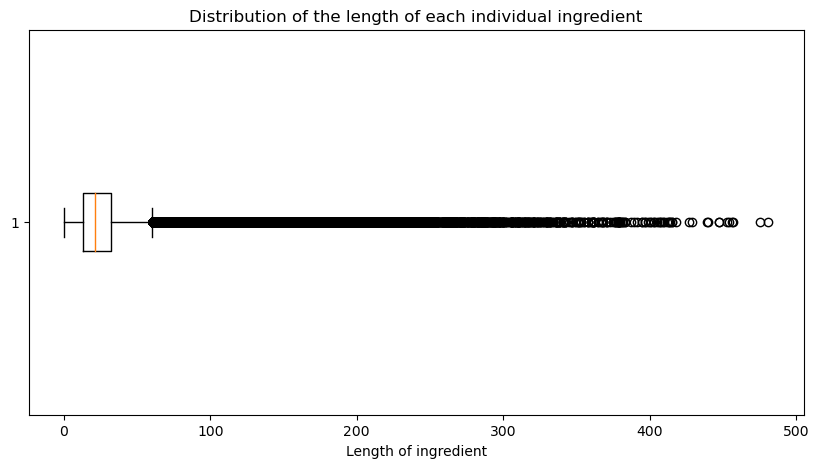

In [12]:
plot_ingredients_length_distribution(all_ingredients)

##### Distribution of the number of ingredients per recipe

Mean number of ingredients per recipe: 23.82057592880688
Median number of ingredients per recipe: 19.0
Max number of ingredients per recipe: 422
Min number of ingredients per recipe: 1


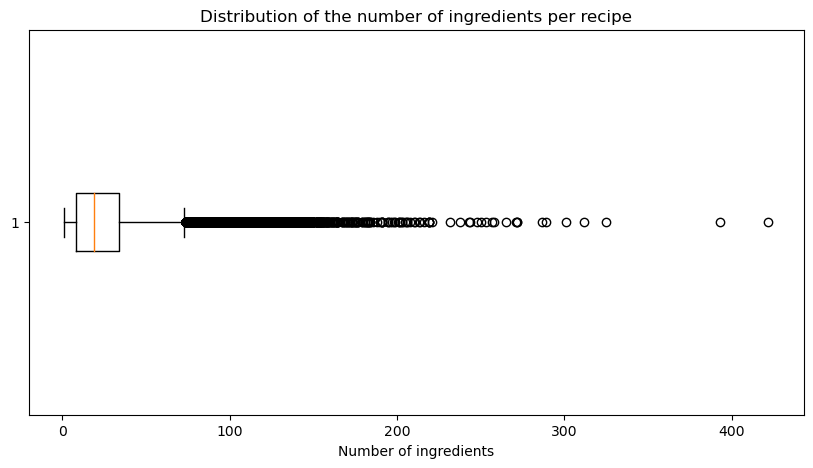

In [13]:
plot_recipe_number_ingredients(all_recipes_ingredients)

##### Ingredient occurences

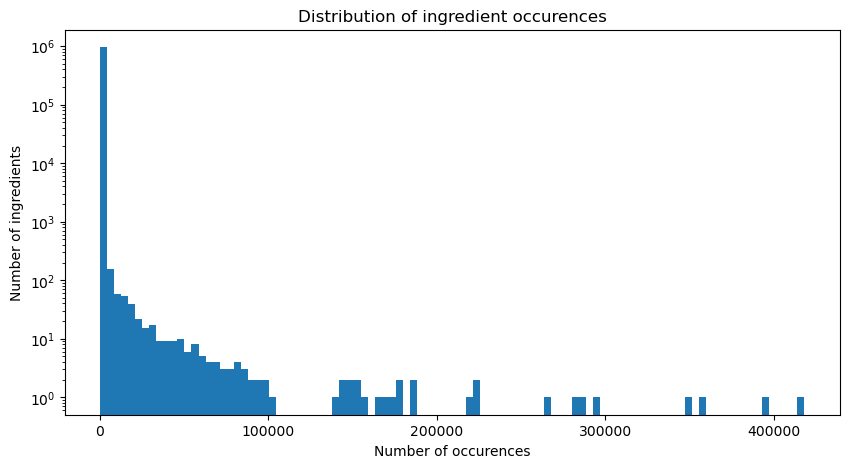

In [14]:
# Plot the distribution of the occurences of ingredients using a log scale
plt.figure(figsize=(10, 5))
plt.hist(counts_ingredients.values(), bins=100, log=True)
plt.title("Distribution of ingredient occurences")
plt.xlabel("Number of occurences")
plt.ylabel("Number of ingredients")
plt.show()

### Filter ingredients with various conditions

In [15]:
clean_ingredients = []

# Ingredients that contain the following words will be removed (this list is not exhaustive and needs to be updated ; this is just a first pass)
banned_ingredients = ["disponible" , "conservé", "conserver", "consommé", "consommer", "minimun"]

for ing in all_ingredients: # For each ingredient
    # Remove ingredients that are a single character
    if len(ing) == 1:
        continue
    # Remove ingredients that contain numbers
    if re.search(r'\d', ing):
        continue
    # Remove ingredients that are in the banned_ingredients list
    banned = False
    for ban in banned_ingredients:
        if ban in ing:
            banned = True
            break
    if banned:
        continue
    # Remove ingredients that don't appear at least 200 times
    if counts_ingredients[ing] < 200:
        continue
    clean_ingredients.append(ing)
unique_clean_ingredients = set(clean_ingredients)

#### Visualizing the clean ingredients

In [16]:
print(f"Total number of clean ingredients: {len(clean_ingredients):,} (with duplicates) (before: {len(all_ingredients):,} ingredients)")
print(f"Number of unique ingredients: {len(unique_clean_ingredients):,} (before: {len(set(all_ingredients)):,} ingredients)")

Total number of clean ingredients: 14,793,306 (with duplicates) (before: 18,940,526 ingredients)
Number of unique ingredients: 2,195 (before: 956,467 ingredients)


##### Distriution of the number of chars of each clean ingredient

Mean length of ingredients: 13.489293849658315
Median length of ingredients: 12.0
Max length of ingredients: 53
Min length of ingredients: 0


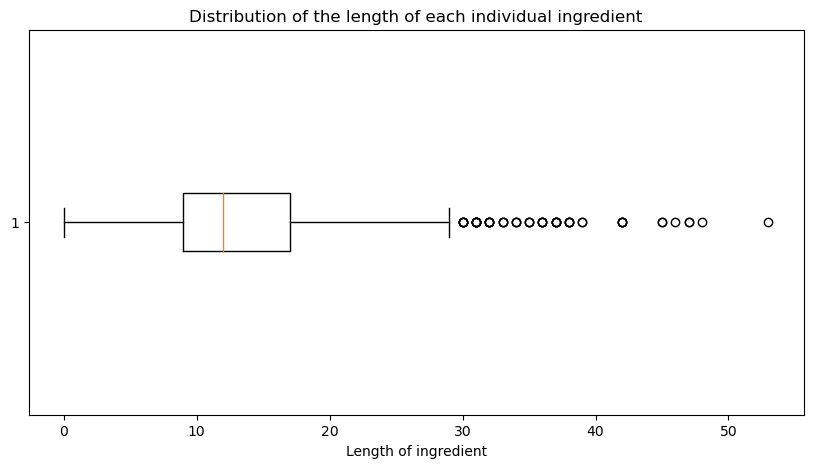

In [17]:
plot_ingredients_length_distribution(set(clean_ingredients))

### Filtering the recipes with clean ingredients

In [18]:
# For each recipe, keep only the ingredients that are in the clean_ingredients list
clean_ingredients_set = set(clean_ingredients)
print("Number of recipes before:", len(all_recipes_ingredients))

recipes_with_clean_ingredients_only = []
for recipe in all_recipes_ingredients:
    recipes_with_clean_ingredients_only.append([ing for ing in recipe if ing in clean_ingredients_set])
print("Number of recipes after:", len(recipes_with_clean_ingredients_only))
print("Number should match the number of recipes before. That is because recipes where all ingredients have been filtered out just have an empty list. If not, there was an error.")

# Remove recipes that have no ingredients left after cleaning
clean_recipes = [recipe for recipe in recipes_with_clean_ingredients_only if len(recipe) > 0]
print("Number of recipes after removing empty recipes:", len(clean_recipes))

Number of recipes before: 795133
Number of recipes after: 795133
Number should match the number of recipes before. That is because recipes where all ingredients have been filtered out just have an empty list. If not, there was an error.
Number of recipes after removing empty recipes: 749122


### Visualizing the number of ingredients fitlered out

In [19]:
diffs = []
for i in range(len(all_recipes_ingredients)):
    diff = len(all_recipes_ingredients[i]) - len(recipes_with_clean_ingredients_only[i])
    diffs.append(diff)

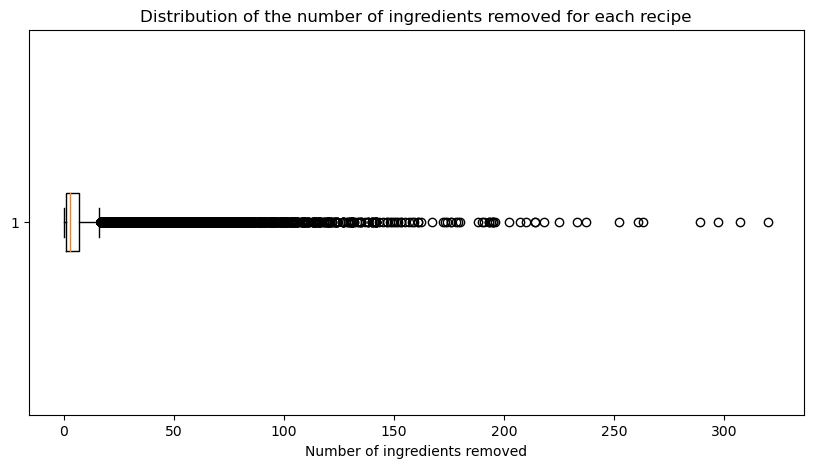

In [20]:
# Plot the distribution of the number of ingredients removed for each recipe
plt.figure(figsize=(10, 5))
plt.boxplot(diffs, vert=False)
plt.title("Distribution of the number of ingredients removed for each recipe")
plt.xlabel("Number of ingredients removed")
plt.show()

In [21]:
# Print the number of recipes that have 0 ingredients after cleaning
print("Number of recipes with 0 ingredients after cleaning:", len([diff for diff in diffs if diff == len(all_recipes_ingredients[i])]))

Number of recipes with 0 ingredients after cleaning: 60324


### Creating a column for the clean ingredients only

In [22]:
df['only_clean_ingredients_kept'] = pd.Series(recipes_with_clean_ingredients_only)
df['number_ingredients'] = df['only_clean_ingredients_kept'].apply(lambda x: len(x))

### Dropping products that do not have ingredients anymore

In [23]:
print("Number of products before filtering:", len(df))
# Remove recipes that have no ingredients left after cleaning
df = df[df['number_ingredients'] > 0]
print("Number of products after filtering:", len(df))

Number of products before filtering: 795133
Number of products after filtering: 749122


In [24]:
print(len)

<built-in function len>


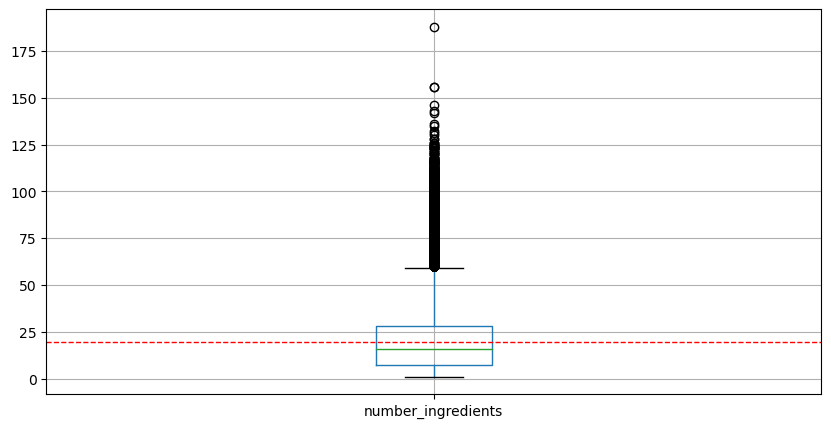

In [25]:
# Plot the boxplot of the number of ingredients per recipe and the distribution of the number of ingredients
df.boxplot(column='number_ingredients', figsize=(10, 5))
# Add a legend for the mean and median
plt.axhline(df['number_ingredients'].mean(), color='r', linestyle='dashed', linewidth=1)

# Vectorizing

## Creating the model

In [26]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 4                        
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 

downsampling = 1e-2   # threshold for configuring which 
                      # higher-frequency words are randomly downsampled
            
# Initialize and train the model 
model = word2vec.Word2Vec(clean_recipes, 
                          workers=num_workers, 
                          vector_size=num_features, 
                          min_count = min_word_count, 
                          window = context,
                          sample = downsampling)

model.init_sims(replace=True)
# According to the documentation, calling init_sims(replace=True) makes the model much more memory-efficient.
# But, it also makes the model read-only, so you can't train it any further.
# If you want to train it further, call init_sims(replace=False) instead.
# However, this is going to be deprecated in the future. It is recommended to use train the model differently instead. Cf. https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

C:\Users\remS\AppData\Local\Temp\ipykernel_142068\2949049990.py:17: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True)


## Exploring similarities based on the wv (word vectors)

### Getting the most similar ingredients to an inputed one

In [27]:
model.wv.most_similar('olive oil')

[('sunflower oil', 0.5561610460281372),
 ('soya oil', 0.48805153369903564),
 ('sesame oil', 0.466129332780838),
 ('avocado oil', 0.4137055277824402),
 ('rice bran oil', 0.39769911766052246),
 ('coconut oil', 0.3927944600582123),
 ('safflower oil', 0.3913480043411255),
 ('hazelnut oil', 0.3666723370552063),
 ('non hydrogenated vegetable oils', 0.3656969666481018),
 ('peanut oil', 0.3599640727043152)]

### Creating a dictionnary of search terms

In [28]:
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)] 
                 for search_term in ['salt','melon','olive', 'chocolate', 'onion']}

# Associate a color to each ingredient
similar_words

{'salt': ['yeast extract',
  'contains live active cultures',
  'white wine extract',
  'vinegar powder',
  'cayenne pepper sauce'],
 'melon': ['quince',
  'lychee',
  'mirabelle plum',
  'dried fruits',
  'fruit puree'],
 'olive': ['olives', 'rose petals', 'plantain', 'mate', 'quinine'],
 'chocolate': ['pepites chocolat au lait',
  'feine milchschokolade',
  'cocoa paste',
  'cocoa bean',
  'cocoa liquor'],
 'onion': ['shallot', 'vegetable', 'yellow carrot', 'dried carrot', 'potato']}

In [29]:
model.wv.most_similar(positive=['salt'])

[('yeast extract', 0.23703625798225403),
 ('contains live active cultures', 0.21542581915855408),
 ('white wine extract', 0.20542217791080475),
 ('vinegar powder', 0.20268039405345917),
 ('cayenne pepper sauce', 0.201617032289505),
 ('evaporated cane syrup', 0.1976465880870819),
 ('la mise en oeuvre', 0.1939825713634491),
 ('evaporated cane sugar', 0.19121210277080536),
 ('skimmed yogurt', 0.19097495079040527),
 ('gum base', 0.18920736014842987)]

In [30]:
model.wv.similarity('salt', 'pepper')

-0.048807748

In [31]:
model.wv.similarity('salt', 'sugar')

-0.04287268

In [32]:
model.wv.similarity('pepper', 'spice')

0.09864322

## Viz

In [33]:
# Create a list of 5 colors that are repeated 6 times (one for each ingredient)
cols = ['red', 'blue', 'green', 'orange', 'purple']
colors = [col for col in cols for i in range(6)]

c:\Users\remS\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\remS\anaconda3\envs\nlp\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


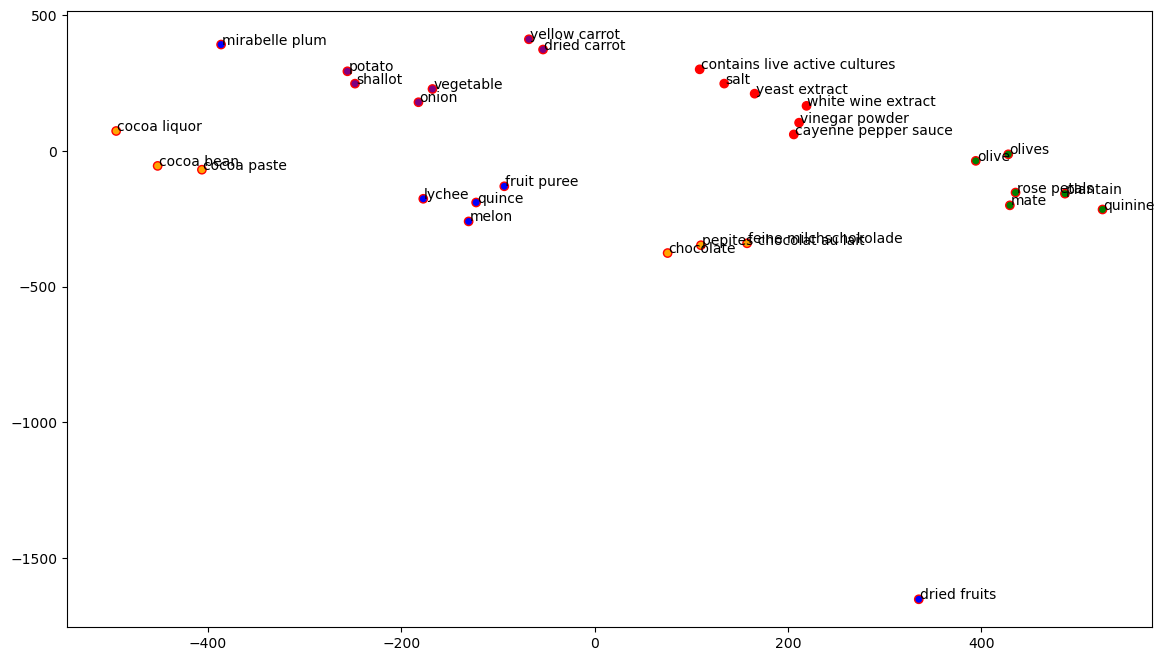

In [34]:
#visualization with Tsne
from sklearn.manifold import TSNE
import numpy as np

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]
tsne = TSNE(n_components=2, random_state=0, n_iter=1000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')